# Fine-tune the GPT2 model to classify spam or not spam texts

## Prepare a dataset and data loader for fine-tuning

### Download and split the dataset for train, validate, test

We use the 'SMS Spam Collection' data set from 'the UC Irvine Machine Learning Repository' which consists of spam and non spam messages.

In [69]:
#download the dataset to a .tsv file
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Downloading the url
    with urllib.request.urlopen(url) as response:
        #write the binary of the url to zip_path
        with open(zip_path, "wb") as f:
            f.write(response.read())

    # Unzipping the file, extract all the elements of zip_path to extracted_path
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # rename Path(extracted_path) / "SMSSpamCollection" to data_file_path
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

sms_spam_collection/SMSSpamCollection.tsv already exists. Skipping download and extraction.


In [70]:
#explore the distribution of the labels of the dataset
import pandas as pd

df = pd.read_csv(data_file_path,sep='\t',header=None,names=['label','text'])
print(df['label'].value_counts())

label
ham     4825
spam     747
Name: count, dtype: int64


In [71]:
#take a look at the spam text messages
df[df['label']=='spam']['text'].to_numpy()[:15]

array(["Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
       "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
       'WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.',
       'Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030',
       'SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info',
       'URGENT! You have won a 1 week FREE membership in our £100,000 Prize Jackpot! Txt the word: CLAIM to No: 81010 T&C www.dbuk.net LCCLTD POBOX 4403LDNW1A7RW18',
       'XXXMobileMovieClub: To

In [72]:
#take a look at the non spam messages
df[df['label']=='ham']['text'].to_numpy()[:15]

array(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
       'Ok lar... Joking wif u oni...',
       'U dun say so early hor... U c already then say...',
       "Nah I don't think he goes to usf, he lives around here though",
       'Even my brother is not like to speak with me. They treat me like aids patent.',
       "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
       "I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.",
       "I've been searching for the right words to thank you for this breather. I promise i wont take your help for granted and will fulfil my promise. You have been wonderful and a blessing at all times.",
       'I HAVE A DATE ON SUNDAY WITH WILL!!',
       "Oh k...i'm watching here:)",
       'Eh u remember how 2 spell his

In [73]:
#create a balanced dataset with 747 spam and non spam texts respectively
def balanced_df(df):
    #get the size of spam
    spam_size=df[df['label']=='spam'].shape[0]
    df_ham=df[df['label']=='ham'].sample(spam_size,random_state=77)
    df_spam=df[df['label']=='spam']
    balanced_df=pd.concat([df_ham,df_spam]).reset_index(drop=True)
    return balanced_df
    
balanced_df=balanced_df(df)

#reset the labels: spam text to label 1
balanced_df['label']=balanced_df['label'].map({'spam':1,'ham':0})
balanced_df['label'].value_counts()

label
0    747
1    747
Name: count, dtype: int64

In [74]:
#shuffle the balanced dataset and split it into train, validate, test set
def split_dataset(df,train_frac,validate_frac):
    df=df.sample(frac=1,random_state=88).reset_index(drop=True)
    train_end=int(len(df)*train_frac)
    val_end=int(len(df)*(train_frac+validate_frac))

    train_df=df[:train_end]
    val_df=df[train_end:val_end]
    test_df=df[val_end:]

    return train_df, val_df, test_df

train_df,val_df,test_df=split_dataset(balanced_df,0.7,0.1) 

In [75]:
# save the datasets as csv file
train_df.to_csv('train.csv',index=None)
val_df.to_csv('val.csv',index=None)
test_df.to_csv('test.csv',index=None)

### Create a dataset and data loader for later use of the model

In [76]:
import tiktoken

tokenizer=tiktoken.get_encoding('gpt2')
print(tokenizer.encode('<|endoftext|>',allowed_special={'<|endoftext|>'}))

[50256]


In [77]:
# organize the data set into a pytorch Dataset class
# truncate and pad the 'text' of the data set to the same length
# so that we can make them a batch in the Dataloader class

import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
    def __init__(self,csv_file,tokenizer,max_len=None,pad_token_id=50256):
        '''
        tokenize the csv file, truncate and pad each text to certain length(need to be within the context len of teh model 1024)
        :param csv_file: the file to tokenize
        :param tokenizer: the tokenizer
        :param max_len: maximum length of each input of the dataset
        :param pad_token_id: token id to pad the input encoded text with
        '''
        df = pd.read_csv(csv_file)
        self.data=df
        self.encoded_texts=[tokenizer.encode(text) for text in self.data['text']]
        #truncate the text greater than max_len
        if max_len is None:
            self.max_len=min(self._max_text_len(),1024)
        else:
            self.max_len=min(max_len,1024)
            self.encoded_texts=[i[:self.max_len] for i in self.encoded_texts]

        #pad the text smaller than max_len
        self.encoded_texts=[i+[pad_token_id]*(self.max_len-len(i)) for i in self.encoded_texts]

    def __getitem__(self,index):
        encoded_text=self.encoded_texts[index]
        label=self.data.iloc[index]['label']
        return torch.tensor(encoded_text, dtype=torch.long),torch.tensor(label, dtype=torch.long)
    
    def __len__(self):
        return len(self.encoded_texts)
    
    def _max_text_len(self):
        m=0
        for text in self.encoded_texts:
            m=max(m,len(text))
        return m

In [78]:
train_dataset=SpamDataset('train.csv',tokenizer)
print(train_dataset.max_len,len(train_dataset))

107 1045


In [79]:
val_dataset=SpamDataset('val.csv',tokenizer,max_len=train_dataset.max_len)
test_dataset=SpamDataset('test.csv',tokenizer,max_len=train_dataset.max_len)

In [80]:
#get the dataloader
from torch.utils.data import DataLoader

batch_size=16

#the training dataloader should drop the last batch to facilitate training
train_dataloader=DataLoader(train_dataset,shuffle=True,batch_size=batch_size,drop_last=True)
val_dataloader=DataLoader(val_dataset,shuffle=True,batch_size=batch_size,drop_last=False)
test_dataloader=DataLoader(test_dataset,shuffle=True,batch_size=batch_size,drop_last=False)

In [81]:
print(len(train_dataloader),len(val_dataloader),len(test_dataloader))

65 10 19


## Get the pretrained GPT2 model from transformers

### Instantiate the gpt2 model architecture

In [82]:

#the gpt2 model architecture
import torch.nn as nn
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert d_out % num_heads == 0, "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads  # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x)  # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.reshape(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)  # optional projection

        return context_vec


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift


class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_resid = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)   # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_resid(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed-forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_resid(x)
        x = x + shortcut  # Add the original input back

        return x


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [83]:
#define configuration and use it to instantiate the model architecture

BASE_CONFIG = {
    "vocab_size": 50257,   
    "context_length": 1024, 
    "drop_rate": 0.0,     
    "qkv_bias": True        
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
}


BASE_CONFIG.update(model_configs["gpt2-small (124M)"])

#instantiate the model
mymodel=GPTModel(BASE_CONFIG)

### Download weights from the pretrained model from transformers

In [84]:
#define function to load the weights of the transformers' model to the instantiated model
import numpy as np
def assign_check(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(right.clone().detach())


def load_weights(gpt, gpt_hf):

    d = gpt_hf.state_dict()

    gpt.pos_emb.weight = assign_check(gpt.pos_emb.weight, d["wpe.weight"])
    gpt.tok_emb.weight = assign_check(gpt.tok_emb.weight, d["wte.weight"])
    
    for b in range(BASE_CONFIG["n_layers"]):
        q_w, k_w, v_w = np.split(d[f"h.{b}.attn.c_attn.weight"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign_check(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign_check(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign_check(gpt.trf_blocks[b].att.W_value.weight, v_w.T)
    
        q_b, k_b, v_b = np.split(d[f"h.{b}.attn.c_attn.bias"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign_check(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign_check(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign_check(gpt.trf_blocks[b].att.W_value.bias, v_b)
    
    
        gpt.trf_blocks[b].att.out_proj.weight = assign_check(gpt.trf_blocks[b].att.out_proj.weight, d[f"h.{b}.attn.c_proj.weight"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign_check(gpt.trf_blocks[b].att.out_proj.bias, d[f"h.{b}.attn.c_proj.bias"])
    
        gpt.trf_blocks[b].ff.layers[0].weight = assign_check(gpt.trf_blocks[b].ff.layers[0].weight, d[f"h.{b}.mlp.c_fc.weight"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign_check(gpt.trf_blocks[b].ff.layers[0].bias, d[f"h.{b}.mlp.c_fc.bias"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign_check(gpt.trf_blocks[b].ff.layers[2].weight, d[f"h.{b}.mlp.c_proj.weight"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign_check(gpt.trf_blocks[b].ff.layers[2].bias, d[f"h.{b}.mlp.c_proj.bias"])
    
        gpt.trf_blocks[b].norm1.scale = assign_check(gpt.trf_blocks[b].norm1.scale, d[f"h.{b}.ln_1.weight"])
        gpt.trf_blocks[b].norm1.shift = assign_check(gpt.trf_blocks[b].norm1.shift, d[f"h.{b}.ln_1.bias"])
        gpt.trf_blocks[b].norm2.scale = assign_check(gpt.trf_blocks[b].norm2.scale, d[f"h.{b}.ln_2.weight"])
        gpt.trf_blocks[b].norm2.shift = assign_check(gpt.trf_blocks[b].norm2.shift, d[f"h.{b}.ln_2.bias"])
    
        gpt.final_norm.scale = assign_check(gpt.final_norm.scale, d[f"ln_f.weight"])
        gpt.final_norm.shift = assign_check(gpt.final_norm.shift, d[f"ln_f.bias"])
        gpt.out_head.weight = assign_check(gpt.out_head.weight, d["wte.weight"])

In [85]:
#get the pretrained gpt2 model from transformers
from transformers import GPT2Model

#tokenizer=AutoTokenizer.from_pretrained('gpt2')
pretrained_model=GPT2Model.from_pretrained("openai-community/gpt2")

#load the weights from the transformers' model to our instantiated model
load_weights(mymodel,pretrained_model)

### Try our loaded model

Check that our loaded model generate coherent text to verify that the weights are loaded successfully.

In [86]:
from generate import top_k_and_temperature,tokenids_decode, text_encode
import tiktoken

enc=tiktoken.get_encoding('gpt2')

text = (
            "Is the following text 'spam'? Answer with 'yes' or 'no':"
            " 'You are a winner you have been specially"
            " selected to receive $1000 cash or a $2000 award.'"
       )

encoded_tensors = text_encode(text, enc)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

out=top_k_and_temperature(encoded_tensors, mymodel, 50, 1024, device, top_k=3,
                        temperature=3)
print(tokenids_decode(out,enc))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'

'You will not be eligible to be selected for any award or to be eligible for the $2000 cash award.

You will not receive a $2000 award if you are unable to make the $2000 award.'

'You


In [87]:
#try other temperature

from generate import top_k_and_temperature,tokenids_decode, text_encode
import tiktoken

enc=tiktoken.get_encoding('gpt2')

text = (
            "Is the following text 'spam'? Answer with 'yes' or 'no':"
            " 'You are a winner you have been specially"
            " selected to receive $1000 cash or a $2000 award.'"
       )

encoded_tensors = text_encode(text, enc)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

out=top_k_and_temperature(encoded_tensors, mymodel, 50, 1024, device, top_k=3,
                        temperature=1)
print(tokenids_decode(out,enc))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' 'Spam' is the term used to refer to any of the following: spamming, malicious activity, malicious activity on the internet, or any other type of spamming, malicious activity that may be directed towards a specific user, or any other


**We can see from above that our pretrained model generate coherent text. However, we want to use it for classification instead of text generation. In the following, we will modify the model architecture, replace the last linear layer with a classification head and fine-tuned the modified model for classification.**

## Finetune the pretrained GPT2 model for spam text classifier

### Adjust the model architecture
We adjust the model architecture as follows:
1. freeze all the model parameters to be non trainable
2. replace the final linear layer `nn.Linear(emb_dim,vocab_size)` of the pretrained model with a classification head `nn.Linear(emb_dim,2)` whose weights are of default value `requires_grad=True`
3. set the parameters of the last transformer block and the last layer normalization to be trainable

In [88]:
#print the architecture of our model
print(mymodel)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

In [89]:
#freeze the whole model
for parameter in mymodel.parameters():
    parameter.requires_grad=False    

In [90]:
#replace the last linear layer with a classification head of two classes
mymodel.out_head = nn.Linear(BASE_CONFIG['emb_dim'],2)
#the weights of the new layer has requires_grad =True by default

In [91]:
#modify the last attention block and the last layer normalization to be trainable

for param in mymodel.final_norm.parameters():
    param.requires_grad=True

for param in mymodel.trf_blocks[-1].parameters():
    param.requires_grad=True

In [92]:
#try the modified model
text = (
            "Is the following text 'spam'? Answer with 'yes' or 'no':"
            " 'You are a winner you have been specially"
            " selected to receive $1000 cash or a $2000 award.'"
       )
enc=tiktoken.get_encoding('gpt2')
encoded_tensors = text_encode(text, enc)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

out=top_k_and_temperature(encoded_tensors, mymodel, 20, 1024, device, top_k=2,
                        temperature=3)
print(tokenids_decode(out,enc))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.'""!"!!"!!!""!"!""!""


### Fine-tune the adjusted model

#### Compute the initial classification loss and accuracy

In [93]:
def cal_loss_batch(input_batch,target_batch,model,device):
    '''
    calculate the loss of the current batch
    :param input_batch: 
    :param target_batch: 
    :param model: 
    :param device: 
    :return: loss tensor of the batch
    '''
    import torch.nn.functional as F
    input_batch=input_batch.to(device)
    target_batch=target_batch.to(device)
    model_out=model(input_batch)
    logits=model_out[:,-1,:]
    loss=F.cross_entropy(logits,target_batch)
    return loss

def cal_loss_loader(dataloader,model,device,n_batches=None):
    model.to(device)
    total_loss=0
    if n_batches is None:
        n_batches=len(dataloader)
    for i,(input_batch,target_batch) in enumerate(dataloader):
        if i<n_batches:
            loss=cal_loss_batch(input_batch,target_batch,model,device)
            total_loss+=loss.item()
    return total_loss/n_batches

In [94]:
#compute the initial loss of the model before fine-tuning
mymodel.eval()
with torch.no_grad():
    train_loss=cal_loss_loader(train_dataloader,mymodel,device)
    val_loss=cal_loss_loader(val_dataloader,mymodel,device)
    test_loss=cal_loss_loader(test_dataloader,mymodel,device)

print(f'The initial train loss is : {train_loss:.3f},\nthe initial validation loss is:{val_loss:.3f},\nthe initial test loss is:{test_loss:.3f}')

The initial train loss is : 0.790,
the initial validation loss is:0.784,
the initial test loss is:0.756


In [95]:
#compute the initial train,validation, test accuracy before fine-tune
def cal_accuracy_loader(dataloader,model,device,num_batches=None):
    '''
    calculate the classification accuracy of a dataloader
    :param dataloader:
    :param model:
    :param device:
    :param num_batches: the number of batches to calculate accuracy
    :return:
    '''
    model.to(device)
    model.eval()
    if num_batches is None:
        num_batches=len(dataloader)
    else:
        num_batches=num_batches
    total_correct,total_samples=0,0
    for i,(input_batch,target_batch) in enumerate(dataloader):
        total_samples+=len(input_batch)
        if i <num_batches:
            input_batch=input_batch.to(device)
            target_batch=target_batch.to(device)
            #print(target_batch.shape)
            with torch.no_grad():
                logits=model(input_batch)[:,-1,:]
            probs=torch.softmax(logits,dim=-1)
            predicted=torch.argmax(probs,dim=-1)
            #print(predicted.shape)
            #predicted shape: (batch_size,)
            #since target_batch is of shape (batch_size), we do not need keepdim=True for torch.argmax()
            correct=torch.sum(predicted==target_batch)
            #print(f'correct is {correct}')
            total_correct+=correct.item()
        else:
            break
        #print(total_correct,total_samples)
    return total_correct/total_samples

In [96]:
train_acc=cal_accuracy_loader(train_dataloader,mymodel,device,num_batches=10)
val_acc=cal_accuracy_loader(val_dataloader,mymodel,device,num_batches=10)
test_acc=cal_accuracy_loader(test_dataloader,mymodel,device,num_batches=10)
print(f'The initial train accuracy is : {train_acc*100:.2f}%,\nthe initial validation accuracy is:{val_acc*100:.2f}%,\nthe initial test accuracy is:{test_acc*100:.2f}%')

The initial train accuracy is : 50.57%,
the initial validation accuracy is:48.67%,
the initial test accuracy is:49.43%


### The fine-tuning loop

In [97]:

#define the training loop for each epoch
def train_one_epoch(model,dataloader,cal_loss_batch,optimizer,device,print_per=1):
    '''
    train the model for one epoch using the dataloader and cal_loss_batch on the device, print the training loss every print_per number of batches
    :param model:
    :param dataloader:
    :param cal_loss_batch: the loss function for the batch
    :param optimizer:
    :param device:
    :param print_per: print the training loss every print_per number of batches
    :return: total_loss_average: total loss average over the dataloader; train_losses_batches: the list of train loss of all the batches
    '''
    #set the model to be in training mode to change the behavior of drop out and batch normalization
    model.to(device)
    model.train()
    train_losses_batches=[]
    sample_size=len(dataloader.dataset)
    current_sample=0
    total_loss=0
    #iterate over all the batches of the dataloader
    for batch_idx, (feature_batch,target_batch) in enumerate(dataloader):
        current_sample+=len(feature_batch)
        #clear out the accumulated gradients
        optimizer.zero_grad()
        #compute the average loss over all samples of the current batch
        loss_batch_average=cal_loss_batch(feature_batch,target_batch,model,device)
        #back propagate the loss and compute the gradients for params with requires_grad=True
        loss_batch_average.backward()
        #update the params with the newly computed gradients according to the optimizer
        optimizer.step()
        
        loss_batch=loss_batch_average.item()
        train_losses_batches.append(loss_batch)
        #print the loss every print_per batches
        if batch_idx % print_per==0:
            print(f'Train loss for current batch {loss_batch:>7f}, [{current_sample:>5d}/{sample_size:>5d}].')
        #compute the total loss over all the batches   
        total_loss+=loss_batch
        
    total_loss_average=total_loss/len(dataloader)
    print(f'\nTrain loss for current epoch {total_loss_average}.\n')
    return total_loss_average, train_losses_batches

#define the evaluation loop
def eval_one_epoch(model,dataloader,cal_loss_batch,device,print_per=1):
    '''
    define the validation loop and return the validation loss average over all the batches
    :param model:
    :param dataloader:
    :param cal_loss_batch:
    :param device:
    :param print_per: print the loss every print_per number of batches
    :return: loss_per_epoch: the validation loss of the epoch; val_losses_batches: the list of validation loss of all the batches
    '''
    #set the model to be in evaluation mode to change the behavior of drop out and batch normalization
    model.to(device)
    model.eval()
    val_losses_batches=[]
    sample_size=len(dataloader.dataset)
    current_sample=0
    loss_total=0
    #tell pytorch not to compute the gradients
    with torch.no_grad():
        for batch_idx, (input_batch, target_batch) in enumerate(dataloader):
            current_sample+=len(input_batch)
            loss_batch_average=cal_loss_batch(input_batch,target_batch,model,device).item()
            val_losses_batches.append(loss_batch_average)
            #print the loss every print_per batches
            if batch_idx % print_per==0:
                print(f'Validation loss for current batch: {loss_batch_average:>7f}, [{current_sample:>5d}/{sample_size:>5d}].')
            loss_total+=loss_batch_average
            
    loss_per_epoch=loss_total/len(dataloader)
    print(f'\nValidation loss for current epoch {loss_per_epoch:>7f}.')
    model.train()
    return loss_per_epoch, val_losses_batches

def train_and_evaluate(n_epochs,model,train_loader,val_loader,test_loader,optimizer,cal_loss_batch,device,print_per=1,num_batches=None):
    '''
    train the model for n_epochs using the train_loader,the optimizer and the loss function on the device, print the training loss every print_per number of batches, evaluate the model and print the validation loss every epoch; accumulate the training loass and the validation loss every epoch and return them
    :param n_epochs: 
    :param model: 
    :param train_loader: 
    :param val_loader: 
    :param test_loader:
    :param optimizer: 
    :param cal_loss_batch: the loss function for the batch
    :param device: 
    :param print_per: print the training loss every print_per step
    :param num_batches: the number of batches used to compute the accuracy
    :return: train_losses_epochs, val_losses_epochs: the training loss, validation loss over all epochs;
    train_losses_batches, val_losses_batches: the lists of training/validation loss over all the batches of all the epoches
    '''
    train_losses_epochs, val_losses_epochs, train_losses_batches, val_losses_batches=[],[],[],[]
    for e in range(n_epochs):
        print(f'Epoch {e+1}\n--------------------------------------')
        train_loss, train_losses_batch=train_one_epoch(model,train_loader,cal_loss_batch,optimizer,device,print_per)
        train_losses_batches.extend(train_losses_batch)
        train_losses_epochs.append(train_loss)
        val_loss,val_losses_batch=eval_one_epoch(model,val_loader,cal_loss_batch,device,print_per=4)
        val_losses_batches.extend(val_losses_batch)
        val_losses_epochs.append(val_loss)
        
        #print the training and validation accuracy every epoch
        train_acc=cal_accuracy_loader(train_loader,mymodel,device,num_batches)
        val_acc=cal_accuracy_loader(val_loader,mymodel,device,num_batches)
        test_acc=cal_accuracy_loader(test_loader,mymodel,device,num_batches)
        print(
            f'\nThe train accuracy for current epoch is: {train_acc*100:.2f}%,\n'
            f'The validation accuracy for current epoch is:{val_acc*100:.2f}%,\n'
            f'The test accuracy for current epoch is:{test_acc*100:.2f}%'
        )
    print('Finished!')
    return train_losses_epochs, val_losses_epochs, train_losses_batches, val_losses_batches

In [98]:
#define the optimizer
optimizer=torch.optim.AdamW(mymodel.parameters(),lr=5e-5,weight_decay=0.1)
n_epochs=15

import time
start_time=time.time()
#finetune the model
train_losses_epochs, val_losses_epochs, train_losses_batches, val_losses_batches=train_and_evaluate(n_epochs=n_epochs,
                                                          model=mymodel,
                                                          train_loader=train_dataloader,
                                                          val_loader=val_dataloader,
                                                          test_loader=test_dataloader,
                                                          optimizer=optimizer,
                                                          cal_loss_batch=cal_loss_batch,
                                                          device=device,
                                                          print_per=20,
                                                          num_batches=None)
end_time=time.time()
total_time_minutes=(end_time-start_time)/60
print(f'Fine-tuning takes {total_time_minutes:.3f} minutes.')

Epoch 1
--------------------------------------
Train loss for current batch 0.730656, [   16/ 1045].
Train loss for current batch 0.704989, [  336/ 1045].
Train loss for current batch 0.654863, [  656/ 1045].
Train loss for current batch 0.638931, [  976/ 1045].

Train loss for current epoch 0.6762309413689833.

Validation loss for current batch: 0.622452, [   16/  150].
Validation loss for current batch: 0.641002, [   80/  150].
Validation loss for current batch: 0.623119, [  144/  150].

Validation loss for current epoch 0.633123.

The train accuracy for current epoch is: 85.48%,
The validation accuracy for current epoch is:83.33%,
The test accuracy for current epoch is:82.61%
Epoch 2
--------------------------------------
Train loss for current batch 0.635158, [   16/ 1045].
Train loss for current batch 0.605346, [  336/ 1045].
Train loss for current batch 0.645138, [  656/ 1045].
Train loss for current batch 0.363271, [  976/ 1045].

Train loss for current epoch 0.5487217467564803.

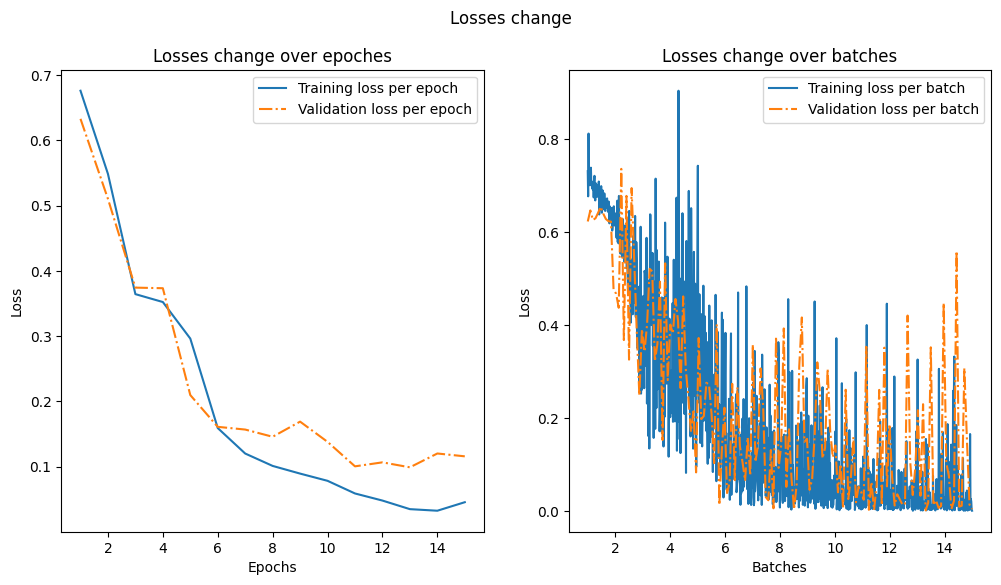

In [99]:
#define a function to plot the training losses and validation losses
import matplotlib.pyplot as plt

def plot_losses(n_epochs,train_losses,val_losses,train_losses_batches, val_losses_batches):
    '''
    plot the training and validation losses every epoch
    :param n_epochs: the number of epochs
    :param train_losses: the accumulated train loss for each epoch
    :param val_losses: the accumulated val loss for each epoch
    :return: None
    '''
    epochs=torch.arange(1,n_epochs+1)
    #fig,axs=plt.subplots(1,2,figsize=(12,6),sharey=True)
    fig,axs=plt.subplots(1,2,figsize=(12,6))
    axs[0].plot(epochs,train_losses,label='Training loss per epoch')
    axs[0].plot(epochs,val_losses,linestyle='-.',label='Validation loss per epoch')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].set_title('Losses change over epoches')
    axs[0].legend(loc='upper right')
    train_batches=torch.linspace(1,n_epochs,len(train_losses_batches))
    axs[1].plot(train_batches,train_losses_batches,label='Training loss per batch')
    val_batches=torch.linspace(1,n_epochs,len(val_losses_batches))
    axs[1].plot(val_batches,val_losses_batches,linestyle='-.',label='Validation loss per batch')
    axs[1].set_xlabel('Batches')
    axs[1].set_ylabel('Loss')
    axs[1].legend(loc='upper right')
    axs[1].set_title('Losses change over batches')
    fig.suptitle('Losses change')
    plt.show()

plot_losses(n_epochs,train_losses_epochs,val_losses_epochs,train_losses_batches, val_losses_batches)

## Use the fine-tuned GPT2 as a spam classifier

In [100]:
#define the function to classify text
def spam_classifier(model,text,tokenizer,device,max_len=train_dataset.max_len,pad_token_id=50256):
    '''
    used the fine-tuned model to classify spam text, encode the text by the tokenizer,  truncate and pad the encoded id to be of teh same size with the size of the dataset used to pretrained teh model
    :param model: the fine-tuned model
    :param text: the text to classify
    :param tokenizer:
    :param device:
    :param max_len: the length of the train data set used for fine-tuning
    :param pad_token_id:
    :return: 
    '''
    encoded_id=tokenizer.encode(text)
    #encoded_id is of type list
    if len(encoded_id)>max_len:
        encoded_id=encoded_id[:max_len]
    encoded_id=encoded_id+[pad_token_id]*(max_len-len(encoded_id))
    #add a batch dimension
    encoded_id=torch.tensor(encoded_id).unsqueeze(0) 
    logits=model(encoded_id)[:,-1,:]
    predicted_class=torch.argmax(logits,dim=1)
    if predicted_class.item() == 0:
        return 'Text is not spam'
    else:
        return 'Text is spam'

In [101]:
# try the fine-tuned model
text1 = 'Hi, long time no see. How are you doing?'
text2 = 'Hi, long time no see. How are you doing? Can you borrow 4000 dollars to me?'
text3 = 'Lucky you! Congratuations on winning the lottory! In order to get the prize, please send 40000 dollars to'
text4 = 'Lucky you! Congratuations on winning the lottory!'
text5 = 'Dear customer, I proundly anounce that we will launch a new product.'
text6 = 'Black Friday! Today is the last day. Do not miss out the chance for sale!'
text7 = 'Black Friday! Today is the last day. Do not miss out the chance!'

tokenizer=tiktoken.get_encoding('gpt2')

print(spam_classifier(mymodel,text1,tokenizer,device))
print(spam_classifier(mymodel,text2,tokenizer,device))
print(spam_classifier(mymodel,text3,tokenizer,device))
print(spam_classifier(mymodel,text4,tokenizer,device))
print(spam_classifier(mymodel,text5,tokenizer,device))
print(spam_classifier(mymodel,text6,tokenizer,device))
print(spam_classifier(mymodel,text7,tokenizer,device))

Text is not spam
Text is not spam
Text is spam
Text is not spam
Text is not spam
Text is spam
Text is not spam


## Save the fine-tuned model

In [102]:
#torch.save(mymodel.state_dict(),'finetuned_text_classifier_gpt2.pth')